# Notebook 5 - LRP

### 1. Imports + Setup

In [1]:
from constants import *

In [2]:
import numpy as np
import cv2
import glob
import matplotlib
import matplotlib.pyplot as plt

# import keras
# from keras import activations
# from keras.utils import CustomObjectScope
# from keras.initializers import glorot_uniform
import tensorflow
from tensorflow.keras.models import load_model

import innvestigate

from vis.visualization import visualize_activation
from vis.utils import utils

SMALL_SIZE = 15
matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=SMALL_SIZE)

Using TensorFlow backend.


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Set up multiple outputs for cells
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### 2. Constants

In [6]:
mobile_net = load_model('mobile_net_v1_rocauc_0.907.h5', compile=False)

In [7]:
# mobile_net = keras.models.load_model('mobile_net_v0_0.88.h5', compile=False)

# with CustomObjectScope({'GlorotUniform': glorot_uniform()}):
#         model = keras.models.load_model('mobile_net_v0_0.88.h5', compile=False)

### 3. Explore melanoma probas

In [17]:
mel_imgs[0].shape

(224, 224, 3)

In [8]:
def read_pre_process_predict_imgs(dir_path='../data_processed/test/mel/*.jpg'):
    imgs = []
    scores = []
    
    all_paths = glob.glob(dir_path)
    
    for path in all_paths:
        # Read image
        img = plt.imread(path)
        # MobileNet pre process + Predict
        score = mobile_net.predict(np.expand_dims(tensorflow.keras.applications.mobilenet.preprocess_input(img),
                                                  axis=0))[0][0]
        # Store imgs and scores
        imgs.append(img)
        scores.append(score)
    
    return imgs, scores

In [9]:
mel_imgs, mel_scores = read_pre_process_predict_imgs()

In [9]:
non_mel_imgs, non_mel_scores = read_pre_process_predict_imgs('../data_processed/test/other/*.jpg')

In [10]:
# # Sort accordingly to score
# mel_scores, mel_imgs = zip(*sorted(zip(mel_scores, mel_imgs)))

### 4. Visualize right and wrong

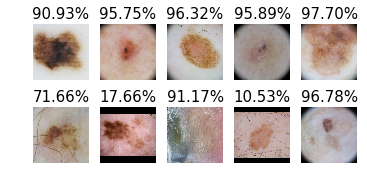

In [10]:
fig = plt.figure(figsize=(12, 12))
for i in range(10):
    _ = plt.subplot(2, 5, i + 1, title='{0:.2%}'.format(mel_scores[i]))
    _ = plt.axis('off')
    _ = plt.imshow(mel_imgs[i])

fig.subplots_adjust(right=.5, top=0.3)
# fig.savefig('')

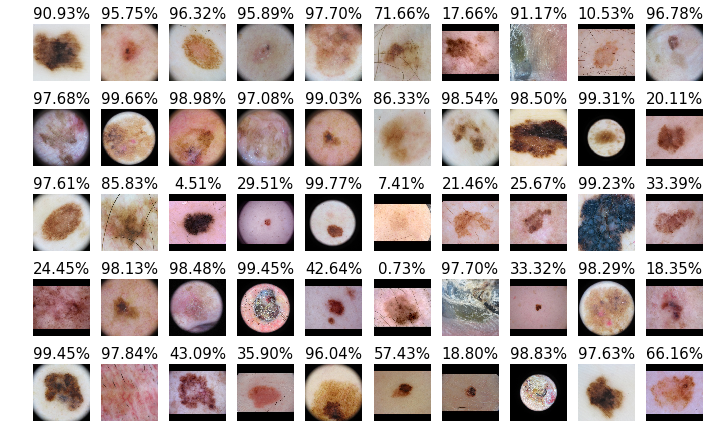

In [11]:
fig = plt.figure(figsize=(12, 12))
for i in range(50):
    _ = plt.subplot(5, 10, i + 1, title='{0:.2%}'.format(mel_scores[i]))
    _ = plt.axis('off')
    _ = plt.imshow(mel_imgs[i])

fig.subplots_adjust(top=.6)
# fig.savefig('')

### 5. Interpretation on right classification

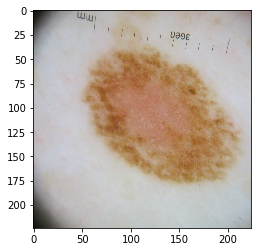

In [12]:
img_1 = mel_imgs[2]
_ = plt.imshow(img_1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


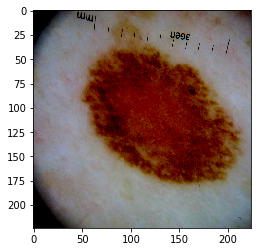

In [13]:
img_1 = tensorflow.keras.applications.mobilenet.preprocess_input(img_1)
_ = plt.imshow(img_1)

In [14]:
analyzer = innvestigate.create_analyzer("gradient", mobile_net)

In [15]:
analysis = analyzer.analyze(img_1)

AttributeError: 'Node' object has no attribute 'output_masks'

In [37]:
explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(img_1, mobile_net.predict, top_labels=2, num_samples=1000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


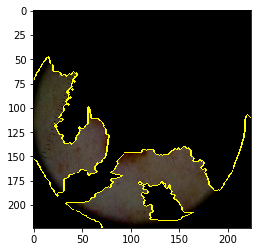

In [38]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, 
                                            num_features=9, hide_rest=True)
plt.imshow(mark_boundaries(temp, mask))

### DeepTaylor

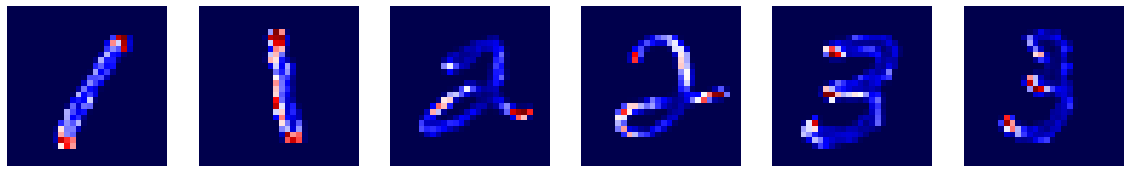

In [24]:
analyzer_dt = innvestigate.analyzer.DeepTaylor(model=model_wo_sm)

fig, axs = plt.subplots(1, 6, sharex=True, sharey=True, figsize=(20,20))

for i in range(len(imagens)):
    axs[i].imshow(analyzer_dt.analyze(imagens[i]).squeeze(), cmap='seismic', interpolation='nearest')
    axs[i].set_axis_off()

### LRPAlphaBeta

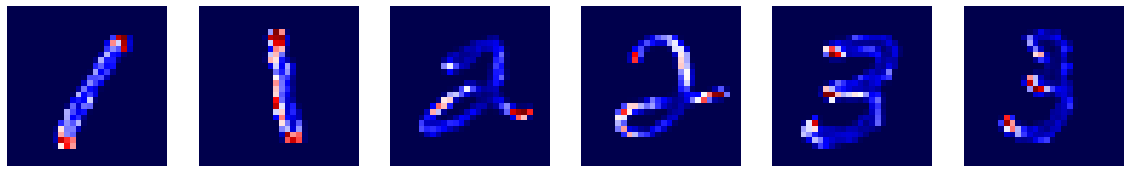

In [25]:
analyzer_lrpa = innvestigate.analyzer.LRPAlphaBeta(alpha=1, model=model_wo_sm)

fig, axs = plt.subplots(1, 6, sharex=True, sharey=True, figsize=(20,20))

for i in range(len(imagens)):
    axs[i].imshow(analyzer_lrpa.analyze(imagens[i]).squeeze(), cmap='seismic', interpolation='nearest')
    axs[i].set_axis_off()